In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

In [3]:
next_station_dict = { 
    'Xavier Hall': 'Fine Arts Annex',
    'Fine Arts Annex': 'Loyola House of Studies',
    'Loyola House of Studies': 'Grade School',
    'Grade School': 'Gate 2.5',
    'Gate 2.5': 'Leong Hall',
    'Leong Hall': 'Xavier Hall'
}

In [4]:
# copy this to scale / unscale
import joblib

colNames = ['Datetime', 'Day', 'Encoded Day', 'Time', 'Hour_of_Day', 'IsEJeep1', 'IsEJeep2', 'Altitude', 'Humidity', 'Temperature', 'Latitude', 'Longitude', 'Lat Diff', 'Long Diff', 'Distance', 'Cum Distance', 'Abs Distance', 'Percent Distance', 'Encoded Station', 'IsStation', 'IsCharging', 'Encoded Prev Station', 'Prev Station Lat', 'Prev Station Long', 'Prev Abs Distance', 'Prev Cum Distance', 'Previous Time to Xavier Hall', 'Previous Time to Fine Arts Annex', 'Previous Time to Loyola House of Studies', 'Previous Time to Grade School', 'Previous Time to Gate 2.5', 'Previous Time to Leong Hall', 'Encoded Next Station', 'Next Station Lat', 'Next Station Long', 'Next Time to Xavier Hall', 'Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall']

scaler = joblib.load("scaler.save")

def scaleOne(scaler, data, colName):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.transform(dummy), columns=colNames)
    return dummy[colName].values

def unscaleOne(scaler, data, colName):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


# example use case
# Scaling
test = pd.DataFrame(columns=['Altitude', 'Next Station Lat', 'Next Time to Gate 2.5'])
test.loc[0] = [153, 14.64, 20000]

print("Unscaled data:", test)

# Unscaling
test['Altitude'] = scaleOne(scaler, test['Altitude'], 'Altitude')
test['Next Station Lat'] = scaleOne(scaler, test['Next Station Lat'], 'Next Station Lat')
test['Next Time to Gate 2.5'] = scaleOne(scaler, test['Next Time to Gate 2.5'], 'Next Time to Gate 2.5')

print("Scaled data:", test)

# Scaling back
test['Altitude'] = unscaleOne(scaler, test['Altitude'], 'Altitude')
test['Next Station Lat'] = unscaleOne(scaler, test['Next Station Lat'], 'Next Station Lat')
test['Next Time to Gate 2.5'] = unscaleOne(scaler, test['Next Time to Gate 2.5'], 'Next Time to Gate 2.5')

print("Unscaled back data:", test)

Unscaled data:    Altitude  Next Station Lat  Next Time to Gate 2.5
0     153.0             14.64                20000.0
Scaled data:    Altitude  Next Station Lat  Next Time to Gate 2.5
0  0.499409          0.869386               0.311659
Unscaled back data:    Altitude  Next Station Lat  Next Time to Gate 2.5
0     153.0             14.64                20000.0


In [46]:
# import data boilerplate

df = pd.read_csv('../Data Preprocessing/Out_v5.csv')

df = df.drop(columns=['Unnamed: 0'])

# make day_limit a 1D dataframe with 1 value
day_limit = pd.DataFrame(columns=['Day'])
day_limit.loc[0] = [29]
day_limit = scaleOne(scaler, day_limit, 'Day')
print(day_limit)

train = df[df['Day'] < day_limit[0]]
test = df[df['Day'] >= day_limit[0]]

y_columns = ['Next Time to Xavier Hall', 'Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall']

train_X = train.drop(columns=y_columns + ['Datetime'])
train_Y = train[y_columns]

test_X = test.drop(columns=y_columns + ['Datetime'])
test_Y = test[y_columns]

[0.95238095]


# XGBoost Regression

In [6]:
from xgboost import XGBRegressor

# xgb objective rmse
model_xgb = XGBRegressor(objective='reg:squarederror')
model_xgb.fit(train_X, train_Y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
model_xgb.save_model('xgb.model')

In [8]:
# Predict the model 
pred = model_xgb.predict(test_X)
# put column labels on prediction
pred = pd.DataFrame(data=pred, columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])

# Bayesian Optimization

In [55]:
### This whole cell is a duplicate all-in-one cell for testing purposes
from xgboost import XGBRegressor

# xgb objective rmse
# model_xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.4006, gamma=0.09115, n_estimators=291)
model_xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.01882, gamma=0.4394, n_estimators=262)
model_xgb.fit(train_X, train_Y)
# Predict the model 
pred = model_xgb.predict(test_X)
# put column labels on prediction
pred = pd.DataFrame(data=pred, columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])

from sklearn.metrics import mean_squared_error as MSE 
  
# Metrics Computation 
rmse = np.sqrt(MSE(test_Y, pred))
r2 = r2_score(test_Y, pred)
mae = mean_absolute_error(test_Y, pred)

print("XGBoost Regression") 
print("RMSE : % f" %(rmse)) 
print("R^2 : % f" %(r2))
print("MAE : % f" %(mae))

XGBoost Regression
RMSE :  0.152979
R^2 :  0.637730
MAE :  0.044668


In [56]:
model_xgb.save_model('xgb_tuned2.model')

In [41]:
!pip install bayesian-optimization==1.4.1
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [51]:
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np

# Define objective function
def xgb_cv(max_depth=None, learning_rate=None, n_estimators=None, subsample=None, colsample_bytree=None, gamma=None):
    params = {
        "objective": "reg:squarederror",
        # "max_depth": int(max_depth),
        "learning_rate": learning_rate,
        "n_estimators": int(n_estimators),
        # "subsample": subsample,
        # "colsample_bytree": colsample_bytree,
        "gamma": gamma,
    }

    # Define cross-validation strategy
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_results = []
    for train_index, test_index in kf.split(train_X, train_Y):
        X_tr, X_te = train_X.iloc[train_index], train_X.iloc[test_index]
        y_tr, y_te = train_Y.iloc[train_index], train_Y.iloc[test_index]

        # Train model
        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr)

        # Evaluate model
        y_pred = model.predict(X_te)
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
        cv_results.append(rmse)

    return np.mean(cv_results)

# Define search space
pbounds = {
    # "max_depth": (3, 9),
    "learning_rate": (0.01, 0.5),
    "n_estimators": (50, 500),
    # "subsample": (0.5, 1),
    # "colsample_bytree": (0.5, 1),
    "gamma": (0, 0.5),
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds)

# Run optimization
optimizer.maximize(init_points=5, n_iter=10)
2
print("Best hyperparameters:", optimizer.max['params'])

# Use best hyperparameters for final model
best_params = optimizer.max['params']
model = XGBRegressor(**best_params)
model.fit(train_X, train_Y)

# Predict on test data
y_pred = model.predict(test_X)

# Evaluate on test data
rmse = np.sqrt(mean_squared_error(test_Y, y_pred))
print("RMSE on test data:", rmse)


|   iter    |  target   |   gamma   | learni... | n_esti... |
-------------------------------------------------------------
| 1         | 0.01079   | 0.309     | 0.4251    | 160.2     |
| 2         | 0.01396   | 0.4394    | 0.01882   | 262.3     |
| 3         | 0.008177  | 0.09115   | 0.4006    | 291.4     |


KeyboardInterrupt: 

# Visualization

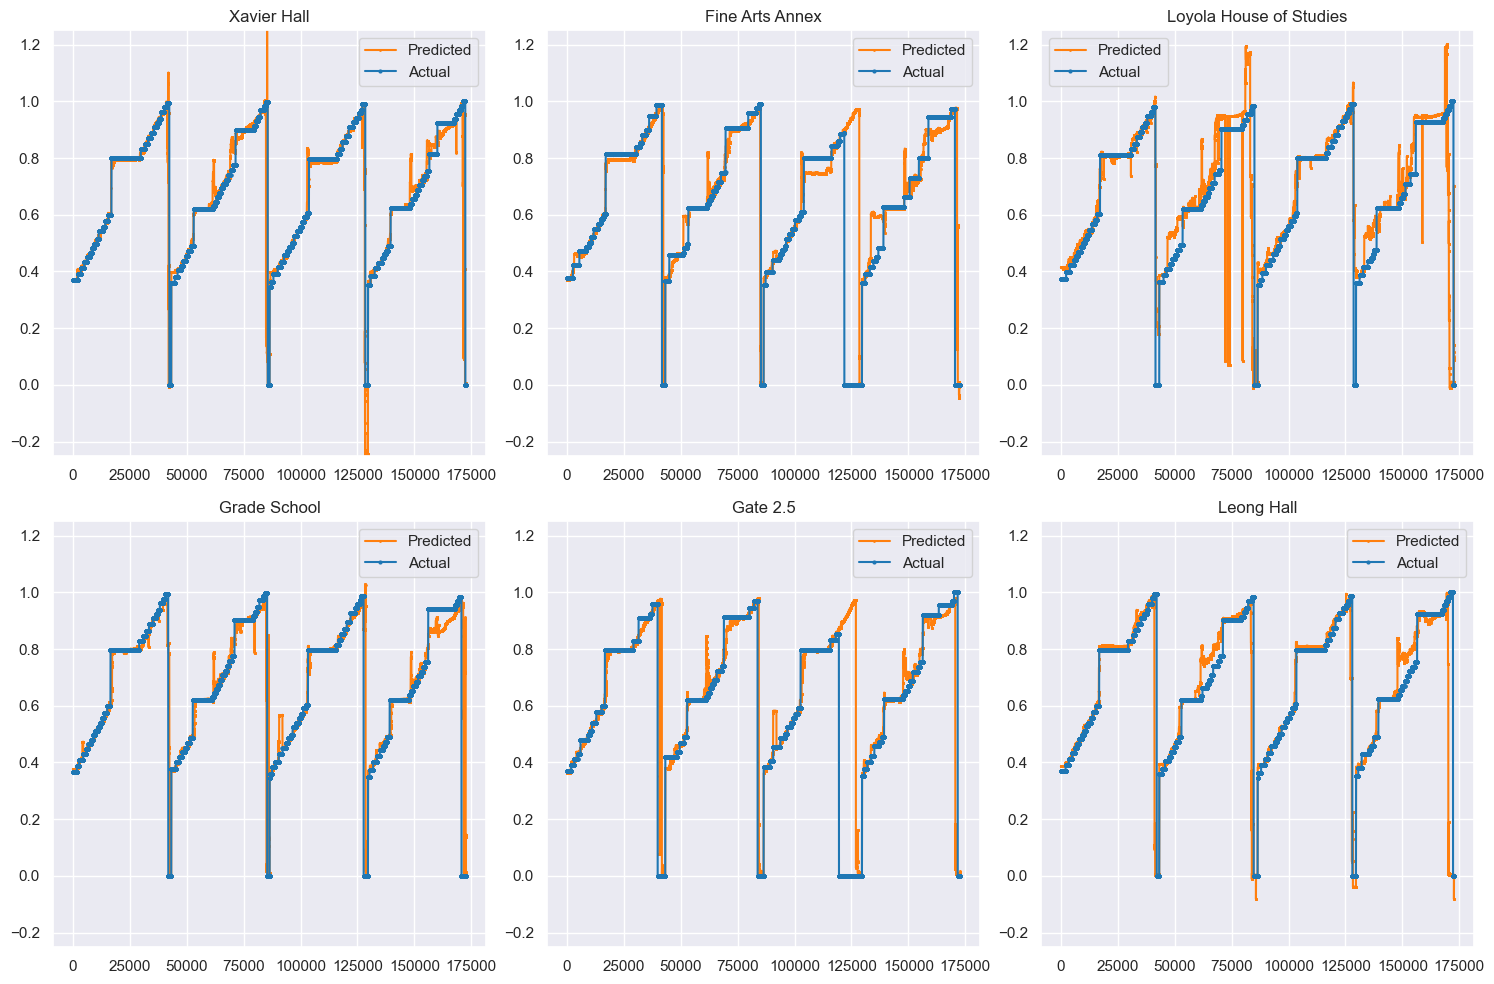

In [57]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

stations = ['Xavier Hall', 'Fine Arts Annex', 'Loyola House of Studies', 'Grade School', 'Gate 2.5', 'Leong Hall']

for i, station in enumerate(stations):
    row = i // 3
    col = i % 3
    
    axs[row, col].plot(pred[f'Next Time to {station}'].values, label='Predicted', marker='o', markersize=1, color='tab:orange')
    axs[row, col].plot(test_Y[f'Next Time to {station}'].values, label='Actual', marker='o', markersize=2, color='tab:blue')
    axs[row, col].set_title(f'{station}')
    axs[row, col].legend()
    axs[row, col].set_ylim(-0.25, 1.25)

plt.tight_layout()
plt.show()

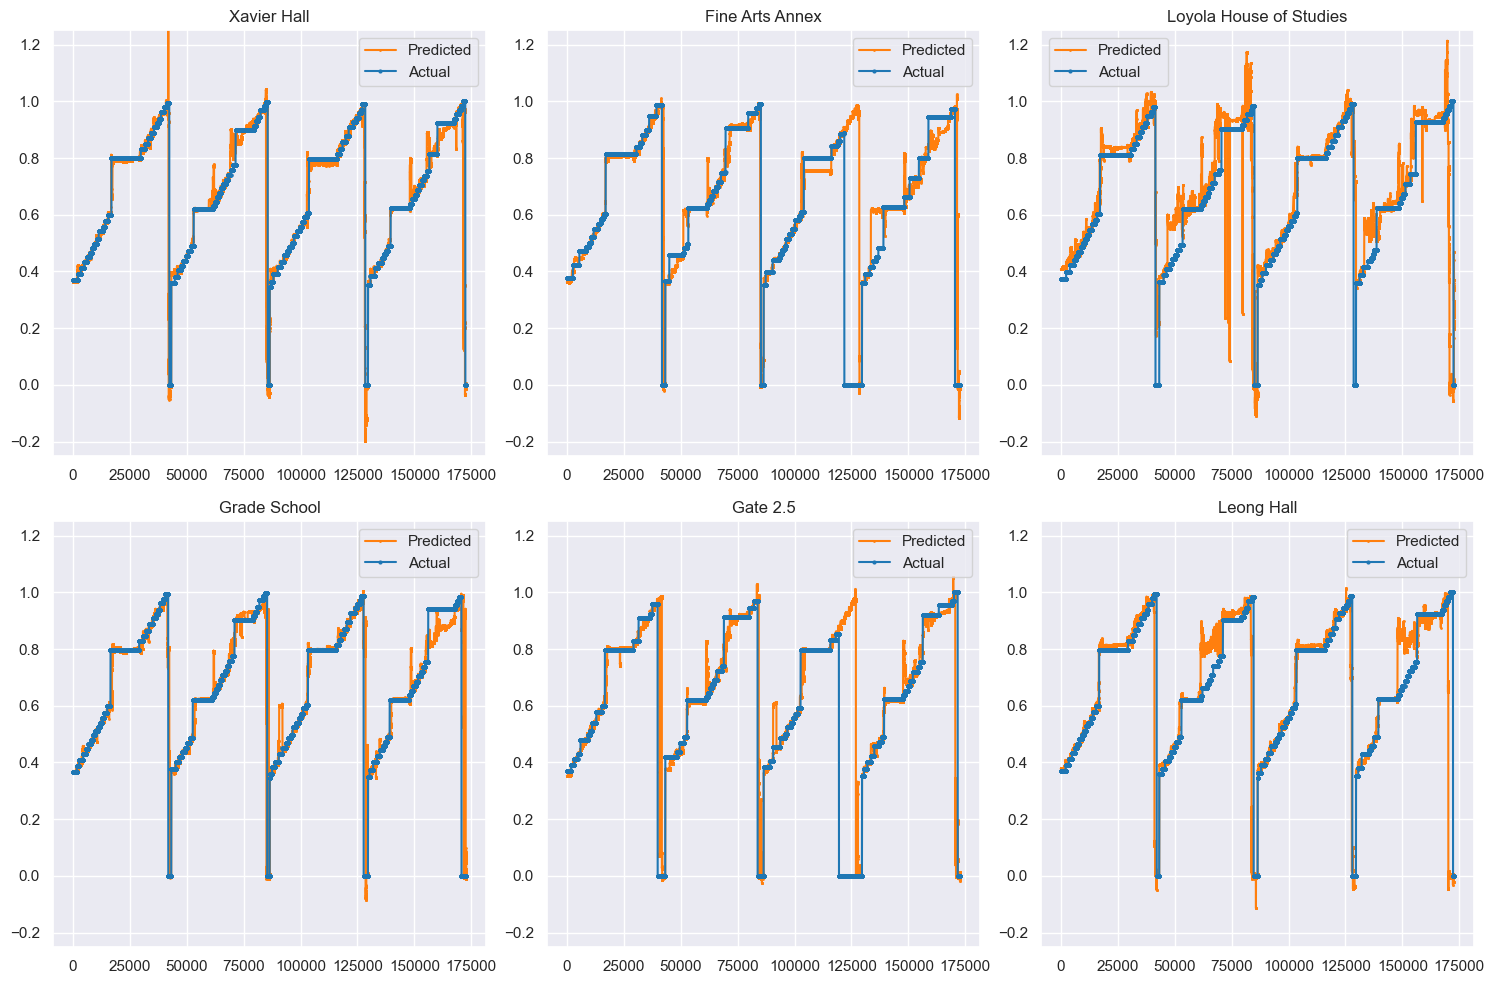

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

stations = ['Xavier Hall', 'Fine Arts Annex', 'Loyola House of Studies', 'Grade School', 'Gate 2.5', 'Leong Hall']

for i, station in enumerate(stations):
    row = i // 3
    col = i % 3
    
    axs[row, col].plot(pred[f'Next Time to {station}'].values, label='Predicted', marker='o', markersize=1, color='tab:orange')
    axs[row, col].plot(test_Y[f'Next Time to {station}'].values, label='Actual', marker='o', markersize=2, color='tab:blue')
    axs[row, col].set_title(f'{station}')
    axs[row, col].legend()
    axs[row, col].set_ylim(-0.25, 1.25)

plt.tight_layout()
plt.show()


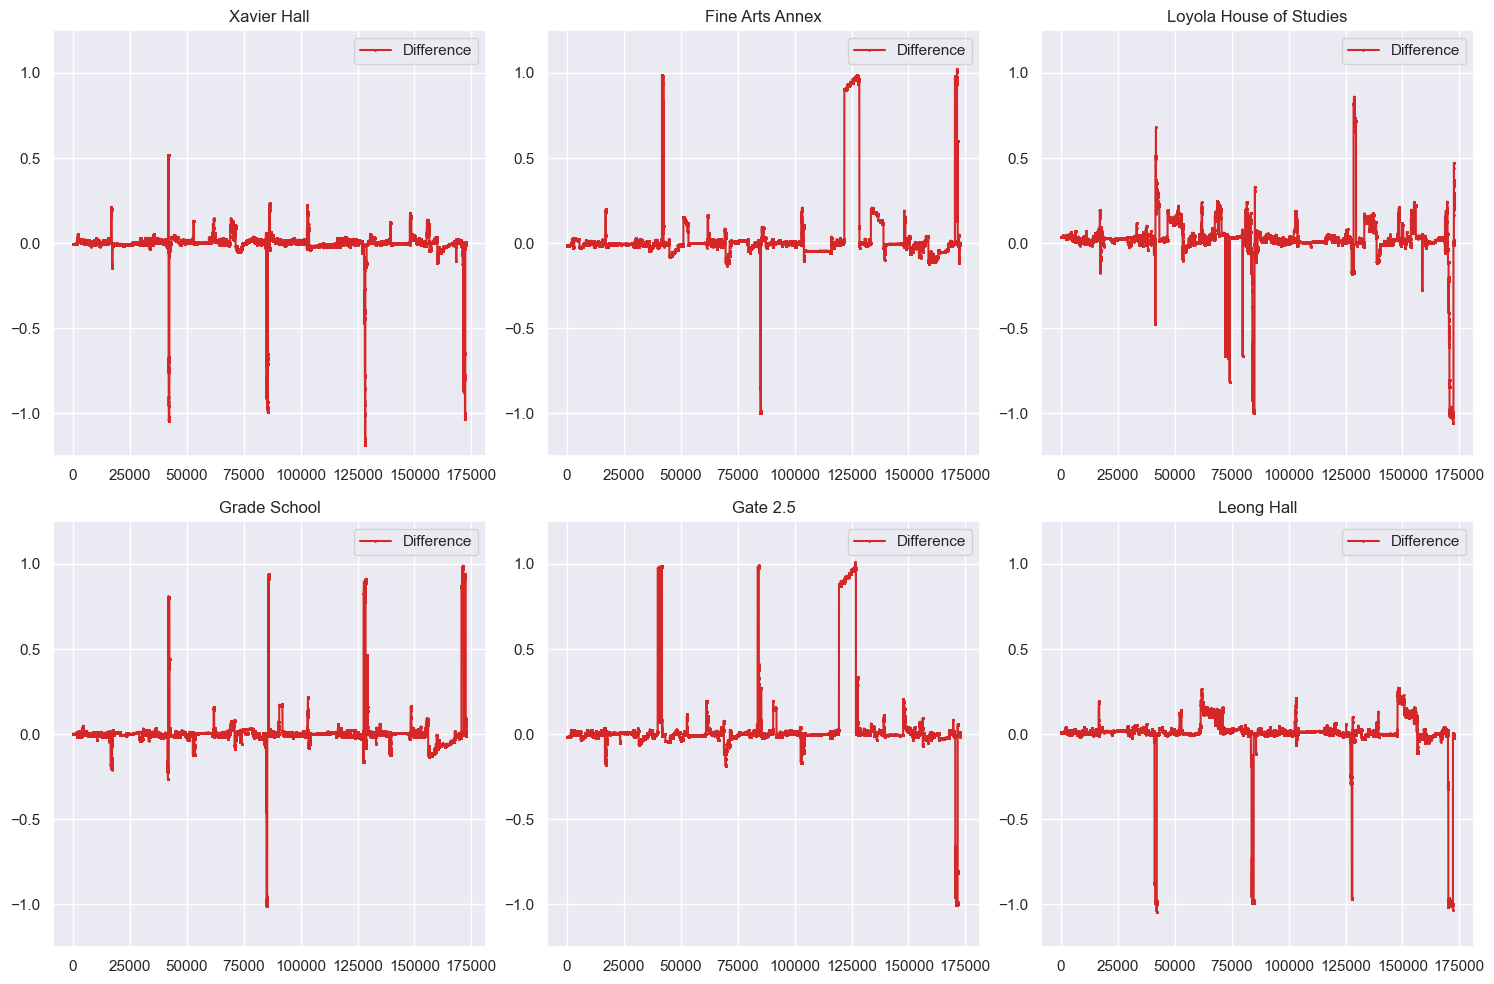

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

stations = ['Xavier Hall', 'Fine Arts Annex', 'Loyola House of Studies', 'Grade School', 'Gate 2.5', 'Leong Hall']

for i, station in enumerate(stations):
    row = i // 3
    col = i % 3
    
    axs[row, col].plot(pred[f'Next Time to {station}'].values - test_Y[f'Next Time to {station}'].values, label='Difference', marker='o', markersize=1, color='tab:red')
    axs[row, col].set_title(f'{station}')
    axs[row, col].legend()
    axs[row, col].set_ylim(-1.25, 1.25)

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error as MSE 
  
# Metrics Computation 
rmse = np.sqrt(MSE(test_Y, pred))
r2 = r2_score(test_Y, pred)
mae = mean_absolute_error(test_Y, pred)

print("XGBoost Regression") 
print("RMSE : % f" %(rmse)) 
print("R^2 : % f" %(r2))
print("MAE : % f" %(mae))

XGBoost Regression
RMSE :  0.154545
R^2 :  0.630924
MAE :  0.045074


In [ ]:
# plot Y_test vs pred
# make color change depending on how close the prediction to the actial value
plt.figure(figsize=(15, 15))
plt.plot(Y_test, pred, 'o', color='black')
plt.xlabel('Y_test')
plt.ylabel('pred')
plt.title('Y_test vs pred')
plt.show()

In [ ]:
# plot how close the prediction to the actual value
plt.figure(figsize=(15, 15))
plt.plot(Y_test, pred.subtract(Y_test.reset_index(drop=True)), 'o', color='black')
plt.xlabel('Y_test')
plt.ylabel('pred - Y_test')
plt.title('XGBoost: Single Prediction Error')
plt.show()

In [ ]:
# plot how close the prediction to the actual value
plt.figure(figsize=(15, 15))
# plt.plot(Y_test['Next Time to Leong Hall'], pred.subtract(Y_test.reset_index(drop=True))['Next Time to Leong Hall'], 'o', color='black')
# plt.xlabel('Y_test')
# plt.ylabel('pred - Y_test')
# plt.title('XGBoost: Single Prediction Error')
# plt.show()

# make a 3x2 graph
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
# go through all stations
for i, station in enumerate(next_station_dict.keys()):
    # plot how close the prediction to the actual value
    axs[i//2, i%2].plot(Y_test[f'Next Time to {station}'], pred.subtract(Y_test.reset_index(drop=True))[f'Next Time to {station}'], 'o', color='black')
    axs[i//2, i%2].set_xlabel('Y_test')
    axs[i//2, i%2].set_ylabel('pred - Y_test')
    axs[i//2, i%2].set_title(f'XGBoost: Single Prediction Error for {station}')

In [ ]:
model_xgb.save_model('xgb.model')

In [ ]:
f_importance_gain = model_xgb.get_booster().get_score(importance_type='gain')
#sort the dictionary
f_importance_gain = sorted(f_importance_gain.items(), key=lambda x:x[1], reverse=True)
f_importance_gain
#plot top 10 features
df_gain = pd.DataFrame(f_importance_gain[:10], columns=['feature', 'gain'])
plt.figure(figsize=(10, 5))
sns.barplot(x='gain', y='feature', data=df_gain)
plt.title('Feature Importance by Gain')
plt.show()


In [ ]:
f_importance_weight = model_xgb.get_booster().get_score(importance_type='weight')
#sort the dictionary
f_importance_weight = sorted(f_importance_weight.items(), key=lambda x:x[1], reverse=True)
f_importance_weight
df_weight = pd.DataFrame(f_importance_weight[:10], columns=['feature', 'weight'])
plt.figure(figsize=(10, 5))
sns.barplot(x='weight', y='feature', data=df_weight)
plt.title('Feature Importance by Weight')
plt.show()


In [ ]:
# XGB plot top 10 important features
from xgboost import plot_importance
plot_importance(model_xgb, max_num_features=10)
plt.show()


In [ ]:
f_importance

In [ ]:
# Check XGBoost Feature importance
# plot feature importance
plt.figure(figsize=(15, 15))
plt.bar(X_train.columns, model_xgb.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('XGBoost: Feature Importance')
plt.show()


In [ ]:
# fig, ax = plt.subplots(figsize=(30, 30))
import xgboost
xgboost.plot_tree(model_xgb, num_trees=1, ax=ax, rankdir='LR', )
# plt.show()


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

length = 60*15  # see past 15 minutes of track
speed = 60*2    # multiplier (1 min per second)

# Create a figure and axis
fig, ax = plt.subplots()

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Animation of Data')
xMin = df['Latitude'].min()
xMax = df['Latitude'].max()
yMin = df['Longitude'].min()
yMax = df['Longitude'].max()

# Define the update function for the animation
def update(frame):
    ax.clear()
    colors = [[]]
    ax.plot(df['Longitude'][frame:frame+length], df['Latitude'][frame:frame+length], color=(0.5,0.5,0.5, 0.5))
    ax.plot(df['Longitude'][frame+length-30:frame+length], df['Latitude'][frame+length-30:frame+length], color=(1-min(df['Distance'][frame+length]*100,1),min(df['Distance'][frame+length]*100,1),min(df['Distance'][frame+length]*100,1)))
    ax.set_xlim(0.9999219332, xMax)  # Set x-axis limits
    ax.set_ylim(0.9989382032, yMax)  # Set y-axis limits
    ax.set_title(f"{frame+length}: \n{df['Next Time to Xavier Hall'][frame+length]}")
    
    if(df['IsStation'][frame+length]):
        ax.scatter(df['Longitude'][frame+length], df['Latitude'][frame+length], color="green")  # Make the station point red and larger
    ax.scatter(df['Next Station Long'][frame+length], df['Next Station Lat'][frame+length], color="purple")
    ax.text(df['Next Station Long'][frame+length], df['Next Station Lat'][frame+length], f"Next Station: {df['Encoded Next Station'][frame+length]}", ha='center', va='bottom', color='purple')
    
    # Add text on the right side
    text_x = xMax + (xMax - xMin) * 0.05  # Adjust the x-coordinate of the text
    text_y = yMax - (yMax - yMin) * 0.05  # Adjust the y-coordinate of the text
    ax.text(text_x, text_y, f"Time: {df['Time'][frame+length]}\nHumidity: {df['Humidity'][frame+length]}", ha='left', va='top')
        
# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(5000,len(df)-length, speed//20), interval=1000//20)

# Display the animation
plt.show()


In [ ]:
### Not working
%%script echo skipping

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

# hyperparamters gird search
model_xgb = XGBRegressor(objective='reg:squarederror')
params = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.2]}
grid = GridSearchCV(estimator=model_xgb, param_grid=params, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid.fit(X_train, Y_train)
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))



# model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)
# model_xgb.fit(X_train, Y_train)

# xgb objective rmse
# model_xgb = XGBRegressor(objective='reg:squarederror')
# model_xgb.fit(X_train, Y_train)

# Predict the model 
# pred = model_xgb.predict(X_test)
# # put column labels on prediction
# pred = pd.DataFrame(data=pred, columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])


# rmse = np.sqrt(MSE(Y_test, pred))
# print(rmse)
